In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [277]:
train_data = pd.read_csv('../DATA/train.csv')
test_data = pd.read_csv('../DATA/test.csv')
submission_data = pd.read_csv('../DATA/sample_submission.csv')

# Data Preprocessing

In [279]:
df = train_data.copy()
df = df.set_index('id')
df = df[['text', 'target']]
df.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


In [280]:
df.isna().sum()

text      0
target    0
dtype: int64

<Axes: xlabel='target', ylabel='count'>

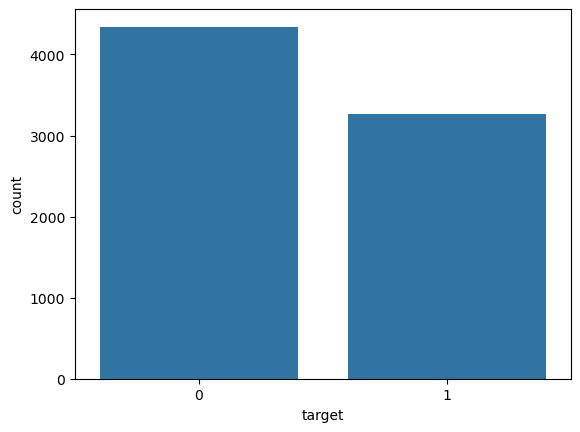

In [281]:
sns.countplot(data=df, x='target')

In [282]:
X = df['text']
y = df['target']

# Data Splitting

In [284]:
from sklearn.model_selection import train_test_split

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Algorithm Selection

In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [288]:
tfid = TfidfVectorizer()
tfid_X_train = tfid.fit_transform(X_train)
tfid_X_test = tfid.transform(X_test)

In [289]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB

In [290]:
def report(model):
    model.fit(tfid_X_train, y_train)
    pred = model.predict(tfid_X_test)
    print(accuracy_score(y_test, pred))
    ConfusionMatrixDisplay.from_estimator(model, tfid_X_test, y_test)
    RocCurveDisplay.from_estimator(model, tfid_X_test, y_test)    

0.8047285464098074


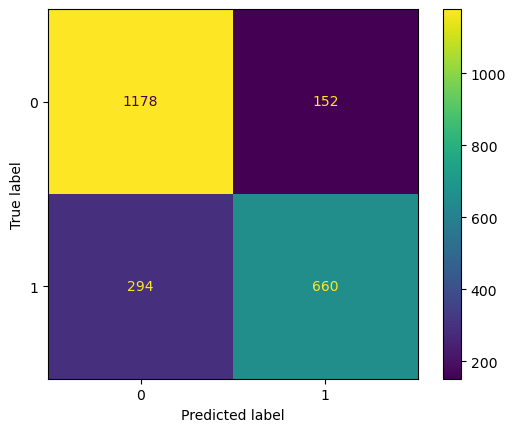

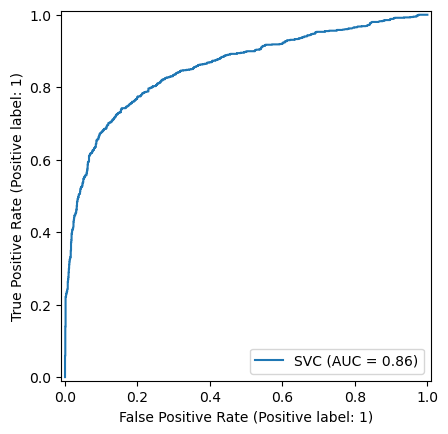

In [291]:
report(SVC())

0.7640105078809106


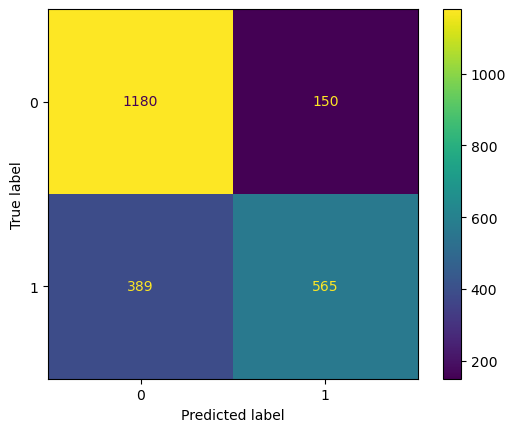

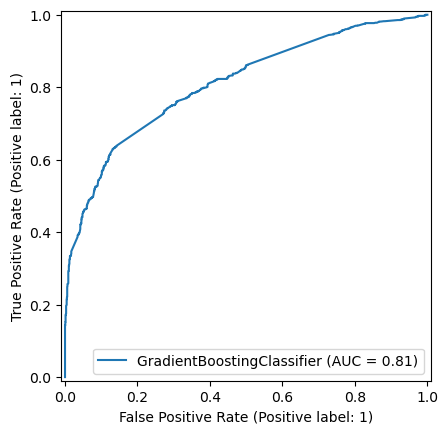

In [292]:
report(GradientBoostingClassifier())

0.7981611208406305


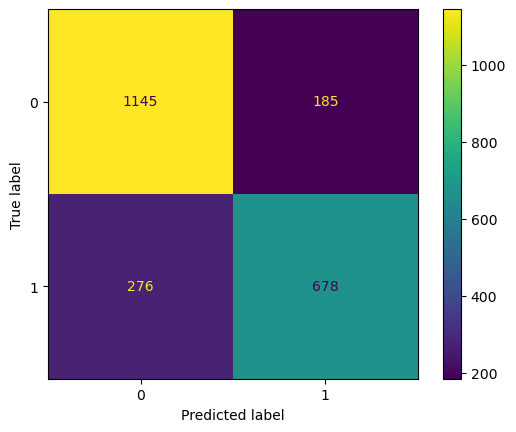

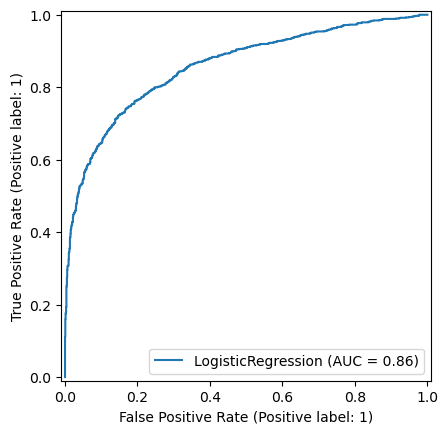

In [293]:
report(LogisticRegression())

0.797723292469352


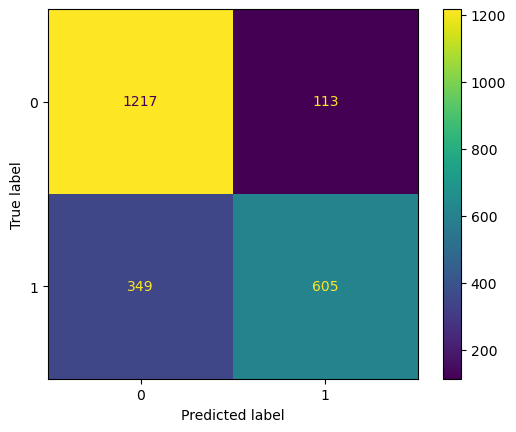

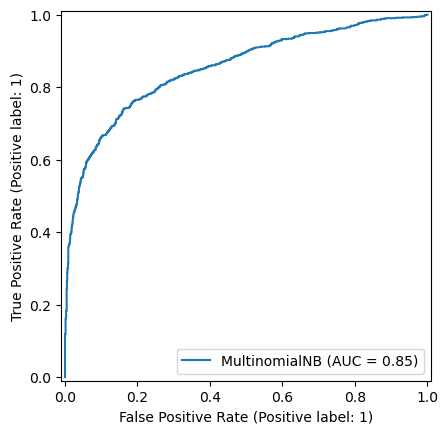

In [294]:
report(MultinomialNB())

# Hyperparameter Optimization

In [307]:
from sklearn.model_selection import GridSearchCV

In [308]:
param_grid = {'C': [1.3],
              'degree': [1]
             }

In [309]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [310]:
grid_model = GridSearchCV(SVC(), param_grid)

In [311]:
grid_model.fit(tfid_X_train, y_train)

GridSearchCV(estimator=SVC(), param_grid={'C': [1.3], 'degree': [1]})

In [312]:
grid_model.best_params_

{'C': 1.3, 'degree': 1}

In [313]:
y_pred = grid_model.predict(tfid_X_test)

In [314]:
accuracy_score(y_test, y_pred)

0.803415061295972

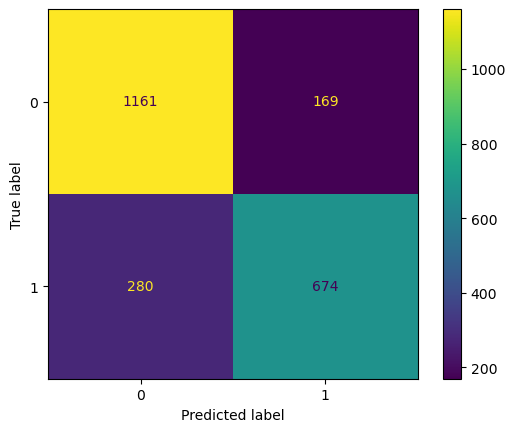

In [315]:
ConfusionMatrixDisplay.from_estimator(grid_model, tfid_X_test, y_test)

In [316]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1330
           1       0.80      0.71      0.75       954

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



# Final model

In [318]:
from sklearn.base import BaseEstimator, TransformerMixin

In [319]:
class transformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed = X_transformed.set_index('id')
        X_transformed = X_transformed['text']
        return X_transformed        

In [320]:
from sklearn.pipeline import Pipeline

In [321]:
final_model = Pipeline([('transformer', transformer()), 
                        ('TfidVectorizer', TfidfVectorizer()),
                        ('svm', SVC(C=1.3, degree=1))])

In [322]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [323]:
final_X = train_data.drop('target', axis=1).copy()
final_y = train_data['target'].copy()

In [324]:
final_X

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...


In [325]:
len(final_X)

7613

In [326]:
len(final_y)

7613

In [327]:
final_model.fit(final_X, final_y)

Pipeline(steps=[('transformer', transformer()),
                ('TfidVectorizer', TfidfVectorizer()),
                ('svm', SVC(C=1.3, degree=1))])

In [328]:
y_preds = final_model.predict(test_data)

In [372]:
prediction = pd.DataFrame(y_preds, test_data['id'])
prediction = prediction.reset_index()
prediction.columns = ['id', 'target']

In [374]:
from joblib import dump

In [376]:
dump(final_model, 'Natural_Language_Processing_with_Disaster_Tweets.joblib')

['Natural_Language_Processing_with_Disaster_Tweets.joblib']

In [388]:
prediction.to_csv('Natural_Language_Processing_with_Disaster_Tweets.csv', index=False)

In [390]:
prediction

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [392]:
submission_data

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
